### 1. Các cài đặt cấu hình cần thiết

 Đăng nhập vào Hugging Face, nhập token khi hệ thống yêu cầu

In [148]:
  from huggingface_hub import login

  # Nhập token API của bạn tại đây
  login()


 Cài đặt package hỗ trợ **Unsloth**

Khi cài đặt xong bạn phải khởi động lại phiên

In [5]:
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-1-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install unsloth



Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --no-1-dir
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

Load dữ liệu và xử lý trích xuất câu hỏi và câu trả lời tham chiếu dùng để đánh giá

In [1]:
import pandas as pd
df = pd.read_excel("B1_a.xlsx")

In [2]:
df = df[["question", "llm_answer"]]
Question = df["question"]
Evaluation = df["llm_answer"]
Question

,question
0,You have successfully logged on a Linux system...
1,What is the following command used for?\nsqlma...
2,"Sam, a web developer, was instructed to incorp..."
3,Which of the following is assured by the use o...
4,What is not a PCI compliance recommendation?\n...
...,...
145,A DDOS attack is performed at layer 7 to take ...
146,A post-breach forensic investigation revealed ...
147,Mirai malware targets loT devices. After infil...
148,"Thomas, a cloud security professional, is perf..."


Cấu hình cho việc upload và xử lý dữ liệu với mô hình Gemini trong môi trường Google Colab.

In [21]:
!pip install -U -q "google-generativeai>=0.8.2"

In [27]:
# import necessary modules.
import base64
import copy
import json
import pathlib
import requests


import PIL.Image
import IPython.display
from IPython.display import Markdown

try:
    # The SDK will automatically read it from the GOOGLE_API_KEY environment variable.
    # In Colab get the key from Colab-secrets ("🔑" in the left panel).
    import os
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except ImportError:
    pass

import google.generativeai as genai

# Parse the arguments

model1 = 'gemini-2.0-flash-exp' # @param {isTemplate: true}
contents_b64 = 'W10=' # @param {isTemplate: true}
generation_config_b64 = 'eyJ0ZW1wZXJhdHVyZSI6MSwidG9wX3AiOjAuOTUsInRvcF9rIjo0MCwibWF4X291dHB1dF90b2tlbnMiOjgxOTJ9' # @param {isTemplate: true}
safety_settings_b64 = "e30="  # @param {isTemplate: true}

gais_contents = json.loads(base64.b64decode(contents_b64))

generation_config = json.loads(base64.b64decode(generation_config_b64))
safety_settings = json.loads(base64.b64decode(safety_settings_b64))

stream = False

# Convert and upload the files

tempfiles = pathlib.Path(f"tempfiles")
tempfiles.mkdir(parents=True, exist_ok=True)


drive = None
def upload_file_data(file_data, index):
    """Upload files to the Files API.

    For each file, Google AI Studio either sent:
    - a Google Drive ID,
    - a URL,
    - a file path, or
    - The raw bytes (`inline_data`).

    The API only understands `inline_data` or it's Files API.
    This code, uploads files to the files API where the API can access them.
    """

    mime_type = file_data["mime_type"]
    if drive_id := file_data.pop("drive_id", None):
        if drive is None:
          from google.colab import drive
          drive.mount("/gdrive")

        path = next(
            pathlib.Path(f"/gdrive/.shortcut-targets-by-id/{drive_id}").glob("*")
        )
        print("Uploading:", str(path))
        file_info = genai.upload_file(path=path, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if url := file_data.pop("url", None):
        response = requests.get(url)
        data = response.content
        name = url.split("/")[-1]
        path = tempfiles / str(index)
        path.write_bytes(data)
        print("Uploading:", url)
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if name := file_data.get("filename", None):
        if not pathlib.Path(name).exists():
            raise IOError(
                f"local file: `{name}` does not exist. You can upload files "
                'to Colab using the file manager ("📁 Files" in the left '
                "toolbar)"
            )
        file_info = genai.upload_file(path, display_name=name, mime_type=mime_type)
        file_data["file_uri"] = file_info.uri
        return

    if "inline_data" in file_data:
        return

    raise ValueError("Either `drive_id`, `url` or `inline_data` must be provided.")


contents = copy.deepcopy(gais_contents)

index = 0
for content in contents:
    for n, part in enumerate(content["parts"]):
        if file_data := part.get("file_data", None):
            upload_file_data(file_data, index)
            index += 1

import json
print(json.dumps(contents, indent=4))

[]


In [ ]:
gemini = genai.GenerativeModel(model_name=model1)


Khởi tạo hàm đánh giá chất lượng câu trả lời được đưa ra bởi mô hình bằng Gemini

In [53]:
def evaluate_explanation_gemini(question, reference_text, model_answer_text):
    prompt = f"""
You are an expert evaluator. Evaluate the quality of an explanation provided by a model based on its accuracy, clarity, and relevance.

### Question:
{question}

### Reference Answer and Explanation:
{reference_text}

### Model Answer and Explanation:
{model_answer_text}

### Evaluation Criteria: First, if model just gives answer under format (A, B, C, D) with no reasoning explaination, give it 20 points overall if correct answer, 0 overall if incorrect and skip below criteria.
- **Accuracy**: Does the answer correctly explain the reference answer and are given with explaination? (50 points)
- **Clarity**: Is the explanation easy to understand and well-structured? (30 points)
- **Relevance**: Is the explanation focused on the question and reference answer? (20 points)

### Task:
Provide a score from 0 to 100 based on the above criteria briefly with no explaination

### Response:
"""
    # Gửi yêu cầu đánh giá tới API của Gemini
    response = gemini.generate_content(
          contents=prompt,
          generation_config=generation_config,
          safety_settings=safety_settings,
          stream=stream,
    )
    return Markdown(response.text)

### 2. Đánh giá mô hình sau khi finetune

Khởi tạo mô hình Llama sau finetune bằng gói **FastLanguageModel** từ **Unsloth**.
 Lưu ý rằng gói này chỉ hỗ trợ mô hình chạy trên GPU T4, vì vậy người dùng cần chọn
đúng loại thời gian chạy là T4 GPU

In [ ]:
from unsloth import FastLanguageModel
max_seq_length = 4084 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model) # Enable native 2x faster inference

messages = [
    {"role": "user", "content": "How can rainbow tables be defeated? \A.  Use of non-dictionary words \B.  All uppercase character passwords \C.  Password salting \D.  Lockout accounts under brute force password cracking attempts"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
)
inputs = inputs.to('cuda')
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids = inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [114]:
list_score = []


Đoạn code dưới đây duyệt qua danh sách câu hỏi, đưa vào mô hình để tạo ra câu trả lời rồi dùng hàm **evaluate_explanation_gemini** đã được định nghĩa bên trên để đánh giá. Vì API key người thi sử dụng là bản miễn phí từ Google AI Studio có giới hạn tokens nên khuyến khích người dùng chạy code trên từng đoạn 15 dữ liệu riêng lẻ nếu không có key bản trả phí. Ví dụ:


```
for i in range(0, 15):
...
for i in range(15, 30):
...
```






In [141]:

for i in range('''bắt đầu''', '''kết thúc'''):  # Duyệt qua tất cả các câu hỏi
    input_text = Question[i]  # Câu hỏi hiện tại
    reference_text = [Evaluation[i]]  # Câu trả lời đúng dưới dạng danh sách

    # Kiểm tra và thêm pad_token nếu cần

    # Mã hóa input_text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to('cuda')

    # Sinh văn bản từ mô hình
    output = model.generate(input_ids=inputs['input_ids'], max_new_tokens=128)
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    evaluation = evaluate_explanation_gemini(input_text, reference_text, prediction)
    print(f"--- Evaluation for Question {i+1} ---")
    markdown_text = evaluation.data  # Lấy dữ liệu (nội dung chuỗi) từ đối tượng Markdown

    # Chuyển đổi chuỗi thành integer nếu có thể
    try:
        integer_value = int(markdown_text)  # Cố gắng chuyển chuỗi thành số nguyên
        print(f"Converted integer value: {integer_value}")
        list_score.append(integer_value)
    except ValueError:
        print("The content is not convertible to an integer.")
    print(integer_value)

--- Evaluation for Question 144 ---
Converted integer value: 75
75
--- Evaluation for Question 145 ---
Converted integer value: 25
25
--- Evaluation for Question 146 ---
Converted integer value: 60
60
--- Evaluation for Question 147 ---
Converted integer value: 20
20
--- Evaluation for Question 148 ---
Converted integer value: 55
55
--- Evaluation for Question 149 ---
Converted integer value: 20
20
--- Evaluation for Question 150 ---
Converted integer value: 0
0


In [142]:
len(list_score)

151

In [143]:
import pandas as pd

# Tạo DataFrame từ list_score
df = pd.DataFrame(list_score, columns=['Score'])

# Hiển thị bảng
df


,Score
0,25
1,20
2,90
3,80
4,15
...,...
146,60
147,20
148,55
149,20


Biểu đồ tần suất mức điểm xuất hiện trên toàn bộ tập đánh giá sau khi finetune mô hình

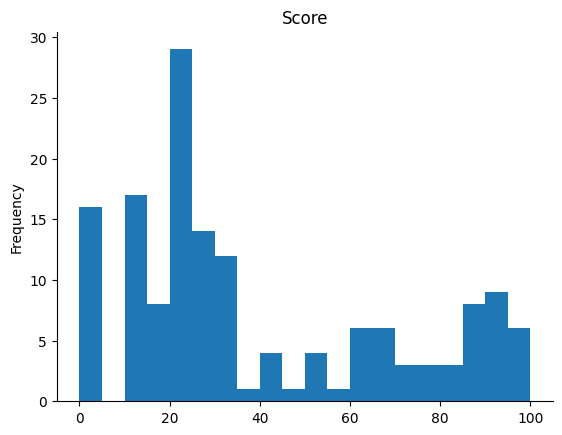

In [146]:
from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Score')
plt.gca().spines[['top', 'right',]].set_visible(False)


Điểm trung bình trên toàn tập dữ liệu

In [147]:
import statistics
print("Average point",statistics.mean(list_score))

Average point 36.88741721854305


### 3. Đánh giá mô hình trước khi finetune


In [166]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
# Import Llama 3.2 1B from Hugging Face
model_name = "meta-llama/Llama-3.2-1B"
max_seq_length = 4096

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model.config.max_seq_length = max_seq_length



OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 13.06 MiB is free. Process 5327 has 14.73 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 21.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
list_score_origin = []

In [ ]:
for i in range(145,150):  # Sử dụng 1 câu hỏi để kiểm tra
    # Sử dụng mô hình như bình thường
    input_text = Question[i]
    if model.config.pad_token_id is None: # Set pad_token_id if not set
        model.config.pad_token_id = model.config.eos_token_id
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)
    if 'attention_mask' not in inputs:
        inputs['attention_mask'] = torch.ones_like(inputs['input_ids'])
    # Sinh văn bản
    output = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=128)

    # In kết quả
    prediction_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Ensure Evaluation[i] is a list of strings
    reference_text = Evaluation[i]  # Assume it's a string, not a list for this case

    # Giả sử evaluate_explanation_gemini là một hàm để đánh giá giải thích từ mô hình
    evaluation = evaluate_explanation_gemini(input_text, reference_text, prediction_text)
    print(f"--- Evaluation for Question {i+1} ---")
    markdown_text = evaluation.data  # Lấy dữ liệu (nội dung chuỗi) từ đối tượng Markdown

    # Chuyển đổi chuỗi thành integer nếu có thể
    try:
        integer_value = int(markdown_text)  # Cố gắng chuyển chuỗi thành số nguyên
        print(f"Converted integer value: {integer_value}")
        list_score_origin.append(integer_value)
    except ValueError:
        print("The content is not convertible to an integer.")

In [ ]:
len(list_score_origin)

In [7]:
import pandas as pd

# Tạo DataFrame từ list_score
df = pd.DataFrame(list_score_origin, columns=['Score'])

# Hiển thị bảng
df


NameError: name 'list_score_origin' is not defined

In [ ]:
# @title Score

from matplotlib import pyplot as plt
df['Score'].plot(kind='hist', bins=20, title='Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
import statistics
print("Average point",statistics.mean(list_score_origin))